In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context(context='notebook',font_scale=1.3)
%matplotlib inline
import pandas as pd
import sqlite3 as sq
import scipy as sp
import sklearn as sk
#f = '/Users/jeffreychapple/Documents/myskedmproject/skedm-master/skedm'
#sys.path.append(f)

In [2]:
import skedm as edm
import buoypy.buoypy as bp

In [3]:
buoy = 41110
year = 2014

H = bp.historic_data(41110,year)

In [4]:
X = H.get_stand_meteo()

In [5]:
X.head();

In [6]:
X.tail();

In [7]:
X.describe();

In [8]:
w = pd.DataFrame(X.WVHT) #extracting jut the wave height
p = pd.DataFrame(X.DPD)  #extracting just the period
wd = pd.DataFrame(X.MWD) #extracting just wind direction
ap = pd.DataFrame(X.APD) #"              "average period
wt = pd.DataFrame(X.WTMP) #"              "water temp

len(w), len(p), len(wd), len(ap), len(wt)


(13680, 13680, 13680, 13680, 13680)

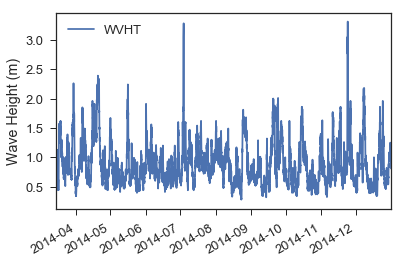

In [9]:
w.plot()
plt.ylabel('Wave Height (m)')


In [10]:
ww = w.resample('D').mean() #resampled the data-> daily avg

In [11]:
ww.head()

,WVHT
2014-03-14,0.552308
2014-03-15,0.783542
2014-03-16,0.592083
2014-03-17,1.348542
2014-03-18,1.414043


In [12]:
ww_array = ww.values.astype(float)
ww_array.shape #note the data has been resampled into daily average
WH = ww_array[:,0]
WH.shape

(293,)

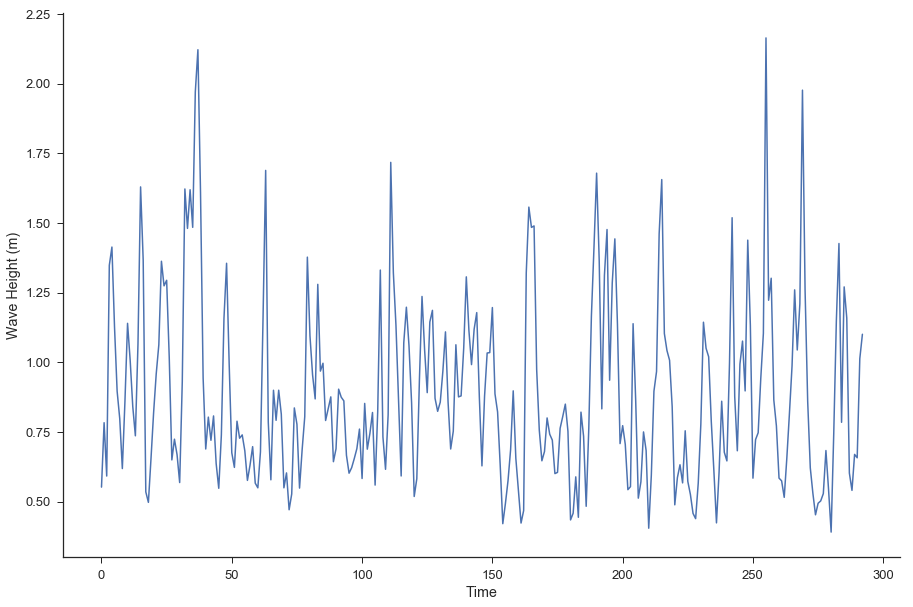

In [13]:
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(WH,linewidth=1.5)
ax.set_xlabel('Time')
ax.set_ylabel('Wave Height (m)')
sns.despine()

# Calculate the mutual information

In [14]:
E = edm.Embed(WH) #initiate the embed class
E

In [15]:
max_lag = 10
mi = E.mutual_information(max_lag)

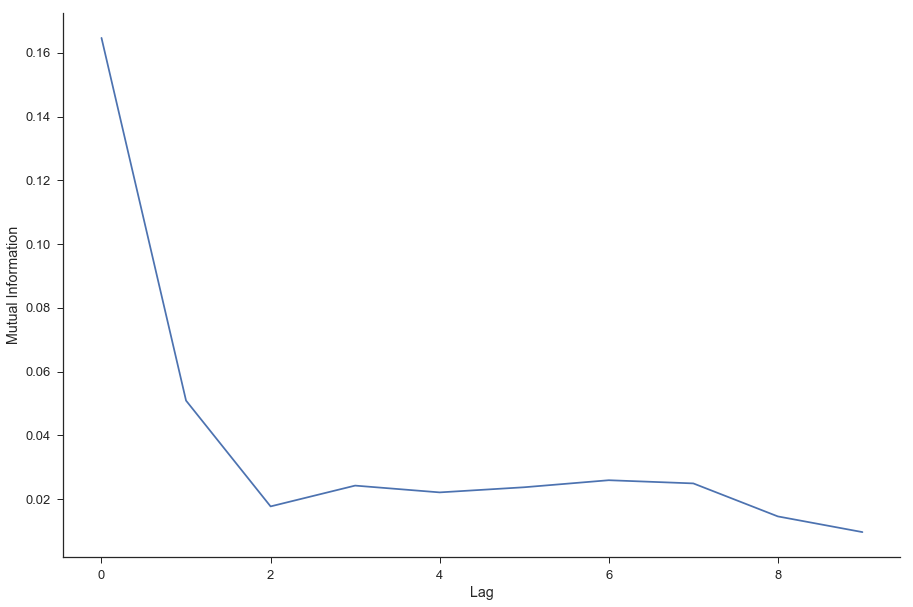

In [16]:
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(mi)
#ax.plot(mi2)
ax.set_xlabel('Lag')
ax.set_ylabel('Mutual Information')
sns.despine()

# Embed the TS embed=2

here the embed dimension is crucial.  Need to graph the embed value on x-axis and Coeff of Det on y axis

In [17]:
lag = 2
embed = 2 #this is the important value embed dimension is = lag(shifts in LR)
predict = 4 #predicting out to double the lag
WH,y = E.embed_vectors_1d(lag,embed,predict)

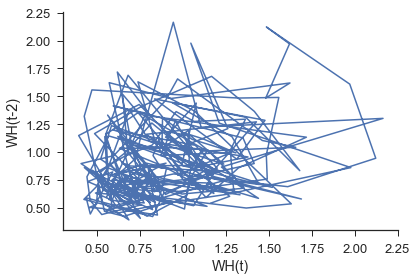

In [18]:
fig,ax = plt.subplots()
ax.plot(WH[:,0],WH[:,1],linewidth=1.5)
ax.set_xlabel('WH(t)')
ax.set_ylabel('WH(t-2)')
sns.despine()


# Train on first 75% of TS

In [19]:
#split it into training and testing sets
train_len = int(.75*len(WH))
Xtrain = WH[0:train_len]
ytrain = y[0:train_len]
Xtest = WH[train_len:]
ytest = y[train_len:]

Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((215, 2), (215, 4), (72, 2), (72, 4))

In [20]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [21]:
M.fit(Xtrain,ytrain) #fit the training data

# Predict last 35% of TS

In [22]:
nn_list = [1,5,10,15]
ypred = M.predict(Xtest,nn_list)
print('ypred type :', type(ypred))
print('ypred len :', len(ypred))

ypred type : <class 'list'>
ypred len : 4


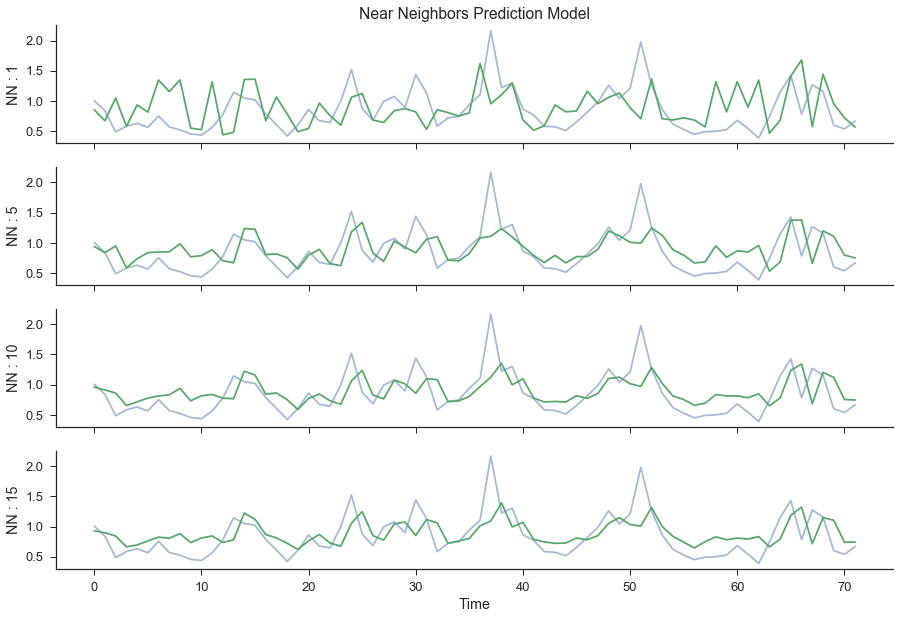

In [23]:
fig,axes = plt.subplots(4,figsize=(15,10),sharex=True,sharey=True)
ax = axes.ravel()


ax[0].plot(ytest[:,0],alpha=.5)
ax[0].plot(ypred[0][:,0])
ax[0].set_ylabel('NN : ' + str(nn_list[0]))
ax[0].set_title('Near Neighbors Prediction Model')

ax[1].plot(ytest[:,0],alpha=.5)
ax[1].plot(ypred[1][:,0])
ax[1].set_ylabel('NN : ' + str(nn_list[1]))

ax[2].plot(ytest[:,0],alpha=.5)
ax[2].plot(ypred[2][:,0])
ax[2].set_ylabel('NN : ' + str(nn_list[2]))


ax[3].plot(ytest[:,0],alpha=.5)
ax[3].plot(ypred[3][:,0])
ax[3].set_ylabel('NN : ' + str(nn_list[3]))
ax[3].set_xlabel('Time')

sns.despine()

# Score the Preds

In [24]:
score = M.score(ytest)

In [25]:
print('score shape:',score.shape)

score shape: (4, 4)


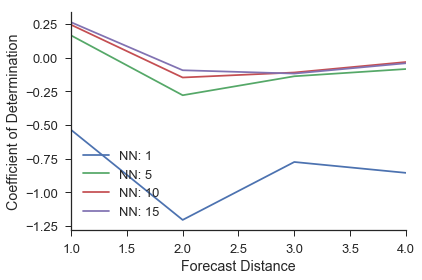

In [26]:
fig,ax = plt.subplots()

for i in range(4):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(range(1,5),score[i],label=label)
    
plt.legend(loc='lower left')
ax.set_ylabel('Coefficient of Determination')
ax.set_xlabel('Forecast Distance')
ax.set_xlim(1,4)
sns.despine()

In [27]:
score

array([[-0.53594048, -1.20439663, -0.77446731, -0.85505923],
       [ 0.16488145, -0.27902029, -0.13820647, -0.08454358],
       [ 0.24379427, -0.14739906, -0.1102871 , -0.0325319 ],
       [ 0.26272834, -0.0935882 , -0.11807446, -0.04159597]])

In [28]:
cd_2 =  0.26272834 #Correlation coefficient 

# embed = 3

In [29]:
lag = 2
embed = 3 #this is the important value embed dimension is = lag(shifts in LR)
predict = 4 #predicting out to double to lag
WH,y = E.embed_vectors_1d(lag,embed,predict)

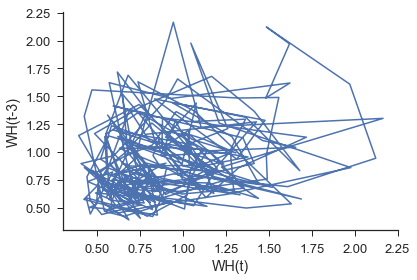

In [30]:
fig,ax = plt.subplots()
ax.plot(WH[:,0],WH[:,1],linewidth=1.5)
ax.set_xlabel('WH(t)')
ax.set_ylabel('WH(t-3)')
sns.despine()


# Train

In [31]:
#split it into training and testing sets
train_len = int(.75*len(WH))
Xtrain = WH[0:train_len]
ytrain = y[0:train_len]
Xtest = WH[train_len:]
ytest = y[train_len:]

Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((213, 3), (213, 4), (72, 3), (72, 4))

In [32]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [33]:
M.fit(Xtrain,ytrain) #fit the training data

# Predict

In [34]:
nn_list = [1,5,10,15]
ypred = M.predict(Xtest,nn_list)
print('ypred type :', type(ypred))
print('ypred len :', len(ypred))

ypred type : <class 'list'>
ypred len : 4


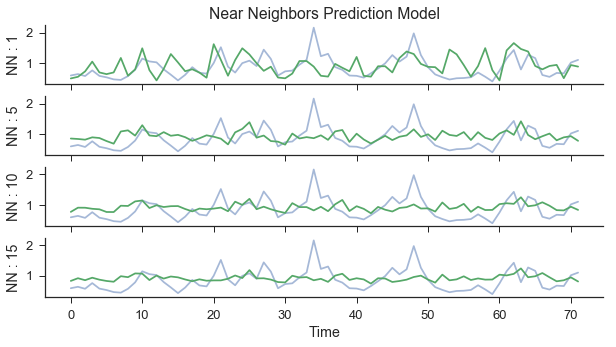

In [37]:
fig,axes = plt.subplots(4,figsize=(10,5),sharex=True,sharey=True)
ax = axes.ravel()


ax[0].plot(ytest[:,3],alpha=.5)
ax[0].plot(ypred[0][:,3])
ax[0].set_ylabel('NN : ' + str(nn_list[0]))
ax[0].set_title('Near Neighbors Prediction Model')

ax[1].plot(ytest[:,3],alpha=.5)
ax[1].plot(ypred[1][:,3])
ax[1].set_ylabel('NN : ' + str(nn_list[1]))

ax[2].plot(ytest[:,3],alpha=.5)
ax[2].plot(ypred[2][:,3])
ax[2].set_ylabel('NN : ' + str(nn_list[2]))


ax[3].plot(ytest[:,3],alpha=.5)
ax[3].plot(ypred[3][:,3])
ax[3].set_ylabel('NN : ' + str(nn_list[3]))
ax[3].set_xlabel('Time')

sns.despine()

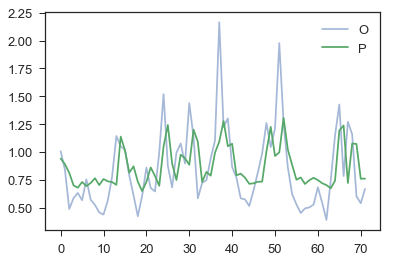

In [38]:
plt.plot(ytest[:,0],alpha=.5)
plt.plot(ypred[3][:,0])
plt.legend('OP')

In [45]:
#score = M.score(ytest[])
#score


# score

In [46]:
score = M.score(ytest)
print('score shape:',score.shape)

score shape: (4, 4)


In [47]:
score

array([[-0.22727209, -1.03045684, -0.80119402, -0.37257163],
       [ 0.24513984, -0.20493797, -0.15405478, -0.12762977],
       [ 0.28999247, -0.11070077, -0.0689795 , -0.06571056],
       [ 0.29120463, -0.03803305, -0.01449976, -0.06303293]])

In [48]:
score[3:]

array([[ 0.29120463, -0.03803305, -0.01449976, -0.06303293]])

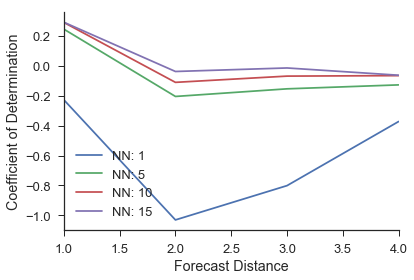

In [49]:
fig,ax = plt.subplots()

for i in range(4):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(range(1,5),score[i],label=label)
    
plt.legend(loc='lower left')
ax.set_ylabel('Coefficient of Determination')
ax.set_xlabel('Forecast Distance')
ax.set_xlim(1,4)
sns.despine()

#### score

In [50]:
cd_3 = 0.29120463

# embed = 4

In [51]:
lag = 2
embed = 4 #this is the important value embed dimension is = lag(shifts in LR)
predict = 4 #predicting out to double to lag
WH,y = E.embed_vectors_1d(lag,embed,predict)

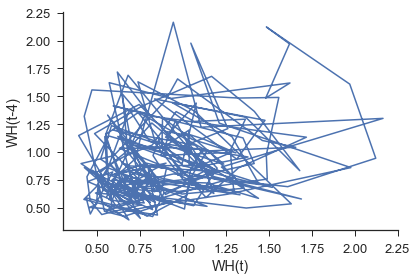

In [52]:
fig,ax = plt.subplots()
ax.plot(WH[:,0],WH[:,1],linewidth=1.5)
ax.set_xlabel('WH(t)')
ax.set_ylabel('WH(t-4)')
sns.despine()


# Train

In [53]:
#split it into training and testing sets
train_len = int(.75*len(WH))
Xtrain = WH[0:train_len]
ytrain = y[0:train_len]
Xtest = WH[train_len:]
ytest = y[train_len:]

Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((212, 4), (212, 4), (71, 4), (71, 4))

In [54]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [55]:
M.fit(Xtrain,ytrain) #fit the training data

# Predict

In [56]:
nn_list = [1,5,10,15]
ypred = M.predict(Xtest,nn_list)
print('ypred type :', type(ypred))
print('ypred len :', len(ypred))

ypred type : <class 'list'>
ypred len : 4


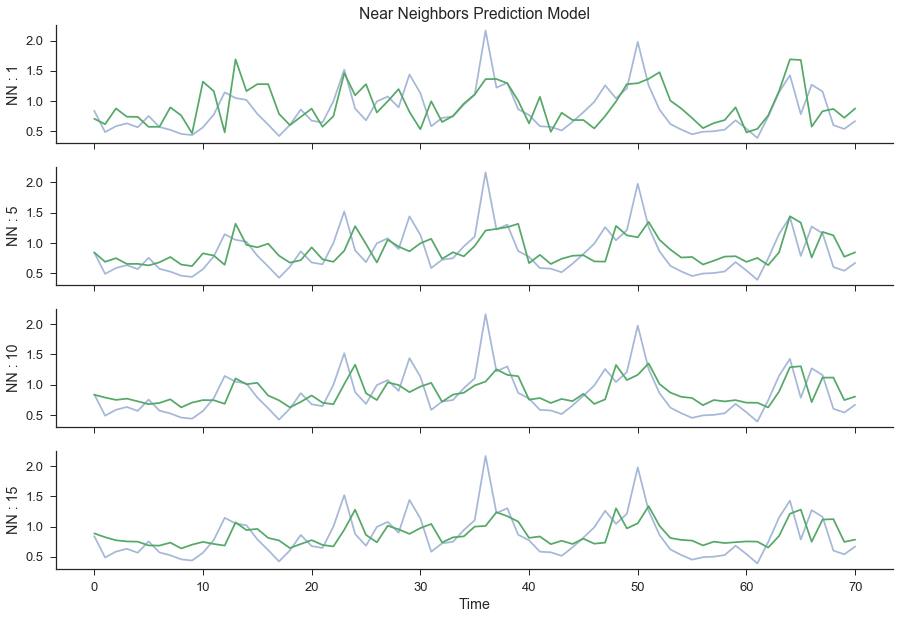

In [57]:
fig,axes = plt.subplots(4,figsize=(15,10),sharex=True,sharey=True)
ax = axes.ravel()

ax[0].plot(ytest[:,0],alpha=.5)
ax[0].plot(ypred[0][:,0])
ax[0].set_ylabel('NN : ' + str(nn_list[0]))
ax[0].set_title('Near Neighbors Prediction Model')

ax[1].plot(ytest[:,0],alpha=.5)
ax[1].plot(ypred[1][:,0])
ax[1].set_ylabel('NN : ' + str(nn_list[1]))

ax[2].plot(ytest[:,0],alpha=.5)
ax[2].plot(ypred[2][:,0])
ax[2].set_ylabel('NN : ' + str(nn_list[2]))


ax[3].plot(ytest[:,0],alpha=.5)
ax[3].plot(ypred[3][:,0])
ax[3].set_ylabel('NN : ' + str(nn_list[3]))
ax[3].set_xlabel('Time')

sns.despine()

# score

In [58]:
score = M.score(ytest)
print('score shape:',score.shape)

score shape: (4, 4)


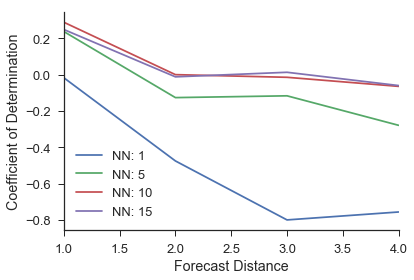

In [59]:
fig,ax = plt.subplots()

for i in range(4):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(range(1,5),score[i],label=label)
    
plt.legend(loc='lower left')
ax.set_ylabel('Coefficient of Determination')
ax.set_xlabel('Forecast Distance')
ax.set_xlim(1,4)
sns.despine()

In [61]:
score

array([[ -1.68116962e-02,  -4.75354618e-01,  -8.00396906e-01,
         -7.56682316e-01],
       [  2.38057648e-01,  -1.26199969e-01,  -1.16345543e-01,
         -2.78964795e-01],
       [  2.89255647e-01,   3.85778663e-04,  -1.42529588e-02,
         -6.42032208e-02],
       [  2.49212809e-01,  -1.16846921e-02,   1.33961945e-02,
         -5.97341153e-02]])

In [62]:
score[1:4]

array([[ 0.23805765, -0.12619997, -0.11634554, -0.27896479],
       [ 0.28925565,  0.00038578, -0.01425296, -0.06420322],
       [ 0.24921281, -0.01168469,  0.01339619, -0.05973412]])

In [63]:
cd_4 =  0.28925565

# embed = 5

In [64]:
lag = 2
embed = 5 #this is the important value embed dimension is = lag(shifts in LR)
predict = 4 #predicting out to double to lag
WH,y = E.embed_vectors_1d(lag,embed,predict)

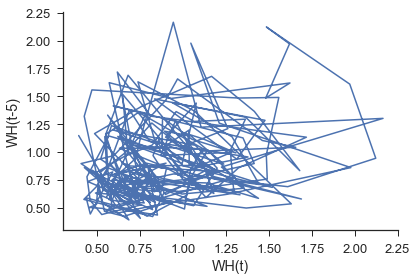

In [65]:
fig,ax = plt.subplots()
ax.plot(WH[:,0],WH[:,1],linewidth=1.5)
ax.set_xlabel('WH(t)')
ax.set_ylabel('WH(t-5)')
sns.despine()


# Train

In [66]:
#split it into training and testing sets
train_len = int(.75*len(WH))
Xtrain = WH[0:train_len]
ytrain = y[0:train_len]
Xtest = WH[train_len:]
ytest = y[train_len:]

Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((210, 5), (210, 4), (71, 5), (71, 4))

In [67]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [68]:
M.fit(Xtrain,ytrain) #fit the training data

# Predict

In [69]:
nn_list = [1,5,10,15]
ypred = M.predict(Xtest,nn_list)
print('ypred type :', type(ypred))
print('ypred len :', len(ypred))

ypred type : <class 'list'>
ypred len : 4


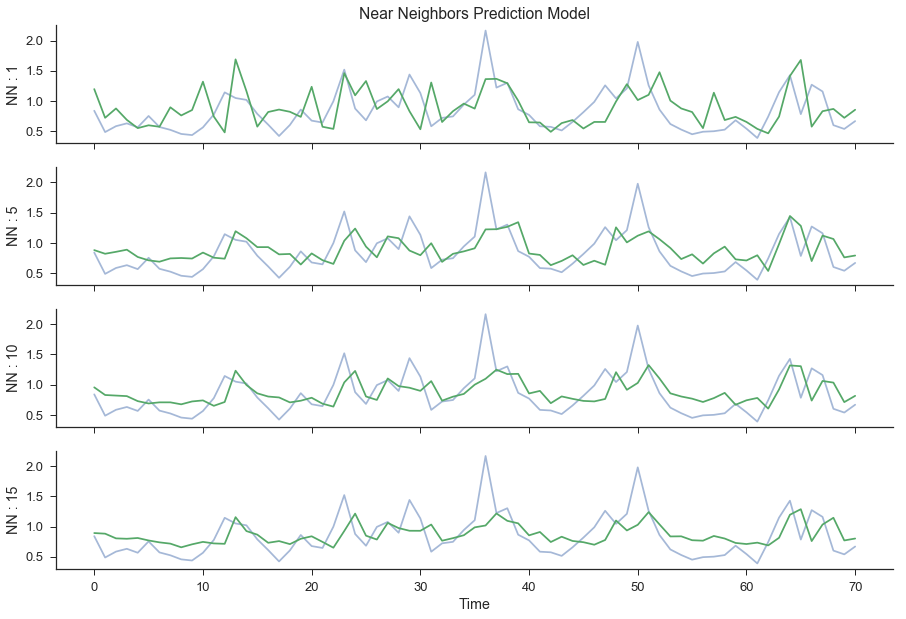

In [70]:
fig,axes = plt.subplots(4,figsize=(15,10),sharex=True,sharey=True)
ax = axes.ravel()

ax[0].plot(ytest[:,0],alpha=.5)
ax[0].plot(ypred[0][:,0])
ax[0].set_ylabel('NN : ' + str(nn_list[0]))
ax[0].set_title('Near Neighbors Prediction Model')

ax[1].plot(ytest[:,0],alpha=.5)
ax[1].plot(ypred[1][:,0])
ax[1].set_ylabel('NN : ' + str(nn_list[1]))

ax[2].plot(ytest[:,0],alpha=.5)
ax[2].plot(ypred[2][:,0])
ax[2].set_ylabel('NN : ' + str(nn_list[2]))


ax[3].plot(ytest[:,0],alpha=.5)
ax[3].plot(ypred[3][:,0])
ax[3].set_ylabel('NN : ' + str(nn_list[3]))
ax[3].set_xlabel('Time')

sns.despine()

# score

In [71]:
score = M.score(ytest) #score the predictions against the actual values

In [72]:
print('score shape:', score.shape)

score shape: (4, 4)


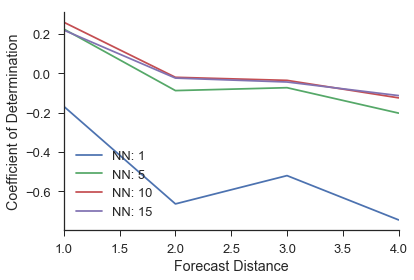

In [73]:
fig,ax = plt.subplots()

for i in range(4):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(range(1,5),score[i],label=label)
    
plt.legend(loc='lower left')
ax.set_ylabel('Coefficient of Determination')
ax.set_xlabel('Forecast Distance')
ax.set_xlim(1,4)
sns.despine()

In [74]:
score

array([[-0.16803183, -0.66360733, -0.51985979, -0.74495776],
       [ 0.22497488, -0.08775143, -0.07305381, -0.20227481],
       [ 0.25956701, -0.02021925, -0.03576227, -0.1247166 ],
       [ 0.21944157, -0.02418707, -0.04412688, -0.11312806]])

In [75]:
score[2:4]

array([[ 0.25956701, -0.02021925, -0.03576227, -0.1247166 ],
       [ 0.21944157, -0.02418707, -0.04412688, -0.11312806]])

In [76]:
cd_5 = 0.2595670

# embed = 6

In [77]:
lag = 2
embed = 6 #this is the important value embed dimension is = lag(shifts in LR)
predict = 4 #predicting out to double to lag
WH,y = E.embed_vectors_1d(lag,embed,predict)

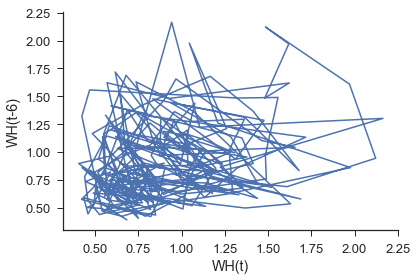

In [78]:
fig,ax = plt.subplots()
ax.plot(WH[:,0],WH[:,1],linewidth=1.5)
ax.set_xlabel('WH(t)')
ax.set_ylabel('WH(t-6)')
sns.despine()


# Train

In [79]:
#split it into training and testing sets
train_len = int(.75*len(WH))
Xtrain = WH[0:train_len]
ytrain = y[0:train_len]
Xtest = WH[train_len:]
ytest = y[train_len:]

Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((209, 6), (209, 4), (70, 6), (70, 4))

In [80]:
weights = 'distance' #use a distance weighting for the near neighbors
M = edm.Regression(weights) # initiate the nonlinear forecasting class

In [81]:
M.fit(Xtrain,ytrain) #fit the training data

# Predict

In [82]:
nn_list = [1,5,10,15]
ypred = M.predict(Xtest,nn_list)
print('ypred type :', type(ypred))
print('ypred len :', len(ypred))

ypred type : <class 'list'>
ypred len : 4


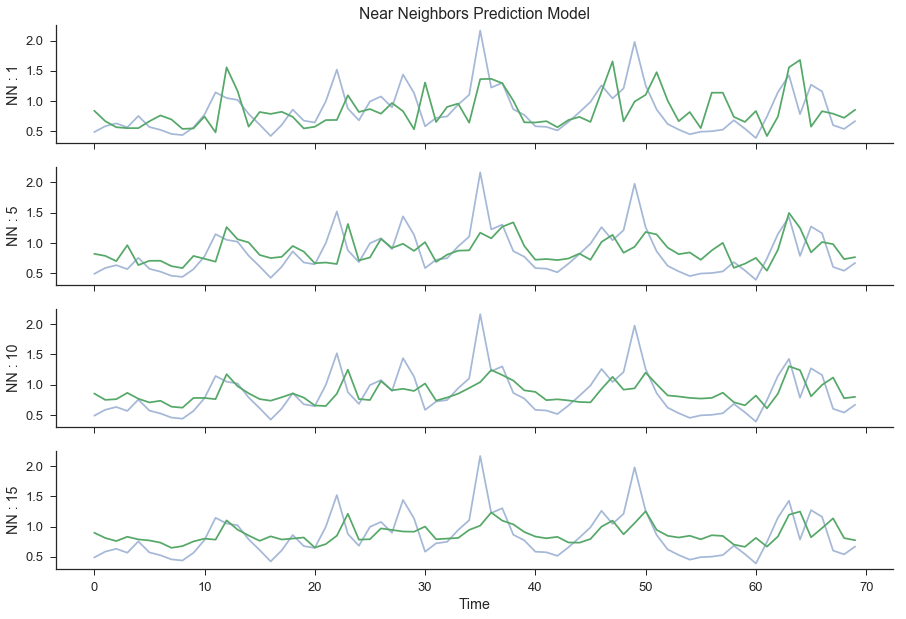

In [83]:
fig,axes = plt.subplots(4,figsize=(15,10),sharex=True,sharey=True)
ax = axes.ravel()

ax[0].plot(ytest[:,0],alpha=.5)
ax[0].plot(ypred[0][:,0])
ax[0].set_ylabel('NN : ' + str(nn_list[0]))
ax[0].set_title('Near Neighbors Prediction Model')

ax[1].plot(ytest[:,0],alpha=.5)
ax[1].plot(ypred[1][:,0])
ax[1].set_ylabel('NN : ' + str(nn_list[1]))

ax[2].plot(ytest[:,0],alpha=.5)
ax[2].plot(ypred[2][:,0])
ax[2].set_ylabel('NN : ' + str(nn_list[2]))


ax[3].plot(ytest[:,0],alpha=.5)
ax[3].plot(ypred[3][:,0])
ax[3].set_ylabel('NN : ' + str(nn_list[3]))
ax[3].set_xlabel('Time')

sns.despine()

# Score

In [84]:
score = M.score(ytest) #score the predictions against the actual values

In [85]:
print('score shape:', score.shape)

score shape: (4, 4)


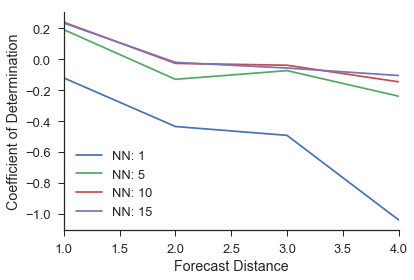

In [86]:
fig,ax = plt.subplots()

for i in range(4):
    label = 'NN: ' + str(nn_list[i]) 
    ax.plot(range(1,5),score[i],label=label)
    
plt.legend(loc='lower left')
ax.set_ylabel('Coefficient of Determination')
ax.set_xlabel('Forecast Distance')
ax.set_xlim(1,4)
sns.despine()

In [87]:
score

array([[-0.12017749, -0.4345819 , -0.49177554, -1.03893699],
       [ 0.1921508 , -0.12917701, -0.07290549, -0.23827864],
       [ 0.24015477, -0.02594223, -0.03801202, -0.14534774],
       [ 0.23492944, -0.01960041, -0.05620753, -0.1047003 ]])

In [88]:
score[1:4]

array([[ 0.1921508 , -0.12917701, -0.07290549, -0.23827864],
       [ 0.24015477, -0.02594223, -0.03801202, -0.14534774],
       [ 0.23492944, -0.01960041, -0.05620753, -0.1047003 ]])

In [89]:
cd_6 = 0.25956701

In [90]:
cd_array = [cd_2,cd_3,cd_4,cd_5,cd_6]
embed = [2,3,4,5,6]
cd_array,embed

([0.26272834, 0.29120463, 0.28925565, 0.259567, 0.25956701], [2, 3, 4, 5, 6])

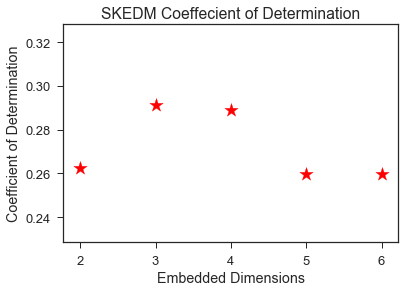

In [91]:
plt.scatter(embed,cd_array,marker='*',c='r',s=200)
plt.xlabel('Embedded Dimensions')
plt.ylabel('Coefficient of Determination')
plt.title('SKEDM Coeffecient of Determination')

In [ ]:
LRcd_array = [0.32476782517081015,
  0.30045285028762858,
  0.30302359419063685,
  0.2961536342559361,
  0.31582463711419062]
Lags = [0,1,2,3,4]

In [ ]:
plt.scatter(Lags,LRcd_array,marker='*',c='m',s=200)
plt.xlabel('Lag')
plt.ylabel('Coefficient of Determination')
plt.title('Linear Regression Coefficient of Determination')